In [1]:
# load libraries
import pandas as pd
import numpy as np
import joblib
import time
import socket
import os
import matplotlib.pyplot as plt
import seaborn as sns

from ranking_cv import ndcg_from_file
from ranking_cv import prec_at_k_from_file

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
exponential_scaling = False

gene_features = ['paccmann']
    
losses = ['approx_ndcg',
          'mse']

models = ['paccmann',
         'nn_baseline']

pred_dir = 'results/preds/'
cv_split_dir = 'cv_splits/'

suffix = '20210617'

cv = 5
ks = [1,3,5,10,15,30]

data_dict = dict()
data_dict['k'] = []
data_dict['model'] = []
data_dict['ndcg'] = []
data_dict['ndcg_std'] = []
data_dict['ndcg_stderror'] = []
data_dict['prec'] = []
data_dict['prec_std'] = []
data_dict['prec_stderror'] = []

data_list_dict = dict()
for loss in losses:
    for model in models:        
        for gene_feature in gene_features:
            ndcg_cv = dict()
            prec_cv = dict()
            for split_nr in range(cv):
                predict_load_path = pred_dir + 'pred_test_' +\
                        str(model) + '_' + str(loss) + '_' +\
                        str(gene_feature)  + '_max_conc_cell_wise' + suffix +\
                        '_' +\
                        str(split_nr) + '.npy'

                predict_csv_path = pred_dir + 'pred_test_' +\
                        str(model) + '_' + str(loss) + '_' +\
                        str(gene_feature) +  '_max_conc_cell_wise' + suffix +\
                        '_' +\
                        str(split_nr) + '.csv'
                
                if not os.path.exists(predict_load_path):
                    print('error: file ' + str(predict_load_path) + ' does not exist')
                    continue

                result_data = np.load(predict_load_path,allow_pickle=True)
                result_data_pd = pd.read_csv(predict_csv_path)
                
                train_df_path = cv_split_dir + '/cv_' + str(cv) + '/train_cv_' + str(cv) +\
                        '_fold_' + str(split_nr) + '_max_conc.csv' 
                test_df_path  = cv_split_dir + '/cv_' + str(cv) + '/test_cv_' + str(cv) +\
                        '_fold_' + str(split_nr) + '_max_conc.csv'
                

                model_name = model + '_' + str(loss) + '_' + str(gene_feature)
                if model_name not in data_list_dict:
                    data_list_dict[model_name] = dict()
                
                for k in ks:
                    if k not in data_list_dict[model_name]:
                        data_list_dict[model_name][k] = dict()
                    if k not in prec_cv:
                        prec_cv[k] = []
                        ndcg_cv[k] = []
                    ndcg = ndcg_from_file(pred_path=predict_csv_path,
                                          gt_test_path=test_df_path,
                                          gt_train_path=train_df_path, 
                                          k=k, exponential_scaling=exponential_scaling)
                    if 'ndcg' not in data_list_dict[model_name][k]:
                        data_list_dict[model_name][k]['ndcg'] = []
                        data_list_dict[model_name][k]['prec'] = []
                    data_list_dict[model_name][k]['ndcg'].append(np.mean(ndcg))
                    
                    prec = prec_at_k_from_file(pred_path=predict_csv_path,
                                               gt_test_path=test_df_path,
                                               gt_train_path=train_df_path,
                                               k=k)
                    data_list_dict[model_name][k]['prec'].append(np.mean(prec))
                    prec_cv[k].append(np.mean(prec))
                    ndcg_cv[k].append(np.mean(ndcg))


            for k in ks:
                if k in ndcg_cv:
                    data_dict['k'].append(k)
                    data_dict['model'].append(model_name)
                    data_dict['ndcg'].append(np.mean(ndcg_cv[k]))
                    data_dict['ndcg_stderror'].append(np.std(ndcg_cv[k]) / np.sqrt(len(ndcg_cv[k])))
                    data_dict['ndcg_std'].append(np.std(ndcg_cv[k]))
                    data_dict['prec'].append(np.mean(prec_cv[k]))
                    data_dict['prec_stderror'].append(np.std(prec_cv[k]) / np.sqrt(len(prec_cv[k])))
                    data_dict['prec_std'].append(np.std(prec_cv[k]))

In [3]:
data_df = pd.DataFrame(data_dict)
data_df.head()

,k,model,ndcg,ndcg_std,ndcg_stderror,prec,prec_std,prec_stderror
0,1,paccmann_approx_ndcg_paccmann,0.888598,0.016082,0.007192,0.493755,0.046381,0.020742
1,3,paccmann_approx_ndcg_paccmann,0.869132,0.008459,0.003783,0.397337,0.018369,0.008215
2,5,paccmann_approx_ndcg_paccmann,0.861589,0.011362,0.005081,0.421913,0.018178,0.008130
3,10,paccmann_approx_ndcg_paccmann,0.869598,0.006215,0.002780,0.475475,0.009141,0.004088
4,15,paccmann_approx_ndcg_paccmann,0.878439,0.008366,0.003741,0.526846,0.008886,0.003974


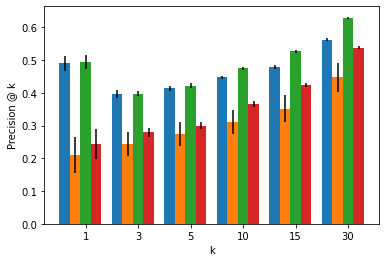

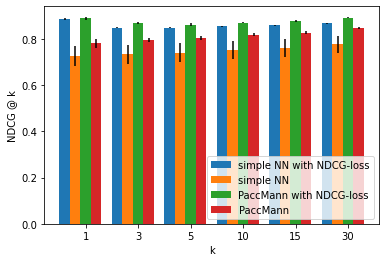

In [4]:
def get_data_for_model(data_df,model):
    tmp_df = data_df[data_df['model'] == model]
    tmp_df = tmp_df.sort_values('k', axis=0, ascending=True)
    return tmp_df


legend_label_mapping = {'krl genes: all_gene':'KRL',
                       'krl genes: paccmann':'KRL with network propagation',
                       'nn_baseline_approx_ndcg_paccmann':'simple NN with NDCG-loss',
                       'nn_baseline_mse_paccmann':'simple NN',
                       'paccmann_approx_ndcg_paccmann':'PaccMann with NDCG-loss',
                       'paccmann_mse_paccmann':'PaccMann'}


unique_models = list(np.unique(np.unique(data_df['model'])))
num_bars = len(unique_models)
ks = list(np.unique(data_df['k']))

ind = np.arange(len(ks))  # the x locations for the groups
width = 1/(num_bars+1)  # the width of the bars
start_offset = width * (num_bars/2)


fig, ax = plt.subplots()#figsize=(15,15))
rects = []
for i in range(num_bars):
    cur_model_name = unique_models[i]
    cur_data = get_data_for_model(data_df,cur_model_name)
    cur_means = list(cur_data['prec'])
    cur_stderror = list(cur_data['prec_stderror'])
    legend_name = legend_label_mapping[cur_model_name]
    rects.append(ax.bar(ind - start_offset + (i*width), cur_means, width, yerr=cur_stderror,
                label=legend_name))
    #print(cur_model_name)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision @ k')
ax.set_xlabel('k')
ax.set_xticks(ind)
ax.set_xticklabels(ks)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#ax.legend()
plt.savefig('prec_at_k_max_conc.pdf',dpi=500)
plt.show()

fig, ax = plt.subplots()#figsize=(15,15))
rects = []
for i in range(num_bars):
    cur_model_name = unique_models[i]
    cur_data = get_data_for_model(data_df,cur_model_name)
    cur_means = list(cur_data['ndcg'])
    cur_stderror = list(cur_data['ndcg_stderror'])
    legend_name = legend_label_mapping[cur_model_name]
    rects.append(ax.bar(ind - start_offset + (i*width), cur_means, width, yerr=cur_stderror,
                label=legend_name))
    #print(cur_model_name)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('NDCG @ k')
ax.set_xlabel('k')
ax.set_xticks(ind)
ax.set_xticklabels(ks)
ax.legend(loc='lower right')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('ndcg_at_k_max_conc.pdf',dpi=500)
plt.show()

### Create the text for the table

In [5]:
legend_label_mapping = {'krl genes: all_gene':'KRL',
                       'krl genes: paccmann':'KRL with network propagation',
                       'nn_baseline_approx_ndcg_paccmann':'simple NN with NDCG-loss',
                       'nn_baseline_mse_paccmann':'simple NN',
                       'paccmann_approx_ndcg_paccmann':'PaccMann with NDCG-loss',
                       'paccmann_mse_paccmann':'PaccMann'}

# p-values for KRL vs. paccmann-ndcg
p_models = ['krl genes: all_gene','paccmann_approx_ndcg_paccmann']

from scipy import stats
from scipy.stats import ranksums


for j in range(len(ks)):
    k = ks[j]
    print('k: ' + str(k))
    
    for i in range(len(unique_models)):
        
        cur_print_string = ''
        cur_model_name = unique_models[i]
        # investigate models for ttest and wilcoxon ranksum test
        ndcg_list = [data_list_dict['paccmann_approx_ndcg_paccmann'][k]['ndcg']]
        prec_list = [data_list_dict['paccmann_approx_ndcg_paccmann'][k]['prec']]
        ndcg_list.append(data_list_dict[cur_model_name][k]['ndcg'])
        prec_list.append(data_list_dict[cur_model_name][k]['prec'])
        
        
        min_length = np.min([len(ndcg_list[0]),len(ndcg_list[1])])
        if cur_model_name != 'paccmann_approx_ndcg_paccmann':
            p_value_ttest  = stats.ttest_rel(ndcg_list[0][0:min_length], ndcg_list[1][0:min_length])
            p_value_wilcox =  stats.ranksums(ndcg_list[0][0:min_length], ndcg_list[1][0:min_length])
        #print(cur_model_name)
        #print(p_value_wilcox)
        #print(ndcg_list[0][0:min_length], ndcg_list[1][0:min_length])
        
        cur_data = get_data_for_model(data_df,cur_model_name)
        # prec at k
        cur_means = list(cur_data['prec'])[j]
        cur_stderror = list(cur_data['prec_stderror'])[j]
        cur_print_string += ' & ' + str(np.round(cur_means,decimals=3)) +\
            '$\pm$' + str(np.round(cur_stderror,decimals=3))
        # ndcg at k
        cur_means = list(cur_data['ndcg'])[j]
        cur_stderror = list(cur_data['ndcg_stderror'])[j]
        cur_print_string += ' & ' + str(np.round(cur_means,decimals=3)) +\
            '$\pm$' + str(np.round(cur_stderror,decimals=3)) 

        legend_name = legend_label_mapping[cur_model_name]
        # model
        if cur_model_name != 'paccmann_approx_ndcg_paccmann':
            cur_print_string += ' & ' + legend_name + ' & ' +\
            str(np.round(p_value_ttest.pvalue,decimals=3)) + ' & ' +\
            str(np.round(p_value_wilcox.pvalue,decimals=3)) + ' \\\\'            
        else:
            cur_print_string += ' & ' + legend_name + ' & - & - \\\\'

        print(cur_print_string)

k: 1
 & 0.491$\pm$0.022 & 0.885$\pm$0.006 & simple NN with NDCG-loss & 0.141 & 0.602 \\
 & 0.211$\pm$0.055 & 0.726$\pm$0.043 & simple NN & 0.02 & 0.009 \\
 & 0.494$\pm$0.021 & 0.889$\pm$0.007 & PaccMann with NDCG-loss & - & - \\
 & 0.245$\pm$0.046 & 0.78$\pm$0.02 & PaccMann & 0.002 & 0.009 \\
k: 3
 & 0.397$\pm$0.011 & 0.849$\pm$0.003 & simple NN with NDCG-loss & 0.003 & 0.009 \\
 & 0.244$\pm$0.037 & 0.734$\pm$0.042 & simple NN & 0.038 & 0.009 \\
 & 0.397$\pm$0.008 & 0.869$\pm$0.004 & PaccMann with NDCG-loss & - & - \\
 & 0.279$\pm$0.014 & 0.795$\pm$0.01 & PaccMann & 0.001 & 0.009 \\
k: 5
 & 0.414$\pm$0.008 & 0.848$\pm$0.003 & simple NN with NDCG-loss & 0.018 & 0.047 \\
 & 0.274$\pm$0.036 & 0.74$\pm$0.041 & simple NN & 0.043 & 0.009 \\
 & 0.422$\pm$0.008 & 0.862$\pm$0.005 & PaccMann with NDCG-loss & - & - \\
 & 0.299$\pm$0.011 & 0.803$\pm$0.008 & PaccMann & 0.001 & 0.009 \\
k: 10
 & 0.448$\pm$0.005 & 0.854$\pm$0.003 & simple NN with NDCG-loss & 0.001 & 0.028 \\
 & 0.311$\pm$0.038 & 0.75